In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

                          IID
imputed_sex Handedness       
0           ambidextrous    3
            left           10
            right          54
1           ambidextrous   26
            left           94
            right         523
2           ambidextrous   39
            left           75
            right         456
                        IID
imputed_sex Hair Color     
0           black         5
            blonde       12
            brown        36
1           black        43
            blonde       77
            brown       247
            other        12
2           black         6
            blonde      127
            brown       212
            other        13


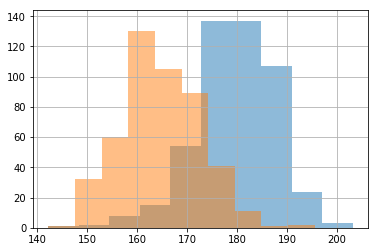

In [2]:
# merge phenotype file and genotype file; a bit tricky handling of IDs, but it works
df=pd.read_csv('phenotypes_202402180100.csv', sep=';')
df['id1'] = df['genotype_filename'].str.split('.').str[0]
df['id2'] = df['genotype_filename'].str.split('.').str[1]
df['id3'] = df['genotype_filename'].str.split('.').str[2]

pheno_list = ['Height', 'Handedness', 'Hair Color']

fam = pd.read_csv('openSNP.fam', delim_whitespace=True, header=None, names=['FID', 'IID', 'MotherID', 'FatherID', 'sex', 'pheno'])
genomeslist = pd.read_csv('opensnp_genomeslist.tsv', sep='\t')
genomeslist['findex']=genomeslist['findex'].astype(int)
genomeslist['sex'] = fam['sex']

genomeslist['id1'] = genomeslist['fn'].str.split('.').str[0]
genomeslist['id2'] = genomeslist['fn'].str.split('.').str[1]
genomeslist['id3'] = genomeslist['fn'].str.split('.').str[2]
genomeslist.drop_duplicates('id3', keep=False, inplace=True)

df=pd.merge(genomeslist[['findex', 'cluster', 'sex', 'id3']], df[pheno_list + ['chrom_sex', 'id3']],on='id3', how='inner')
df.rename(columns={'findex':'IID','sex':'imputed_sex', 'chrom_sex':'reported_sex'}, inplace=True)
df=df[['IID','cluster', 'imputed_sex', 'reported_sex'] + pheno_list].drop_duplicates()


# QC height data

def parse_height(val):
    bucket = None
    if val=='-': return None, None
    val=val.lower()
    if val == '>200cm': return 'tall', None
    if val == '1m87': val='187 cm'
    if val in ['163.195cm', 'gg', 'rs6060371', 'ttcc']: return None, None
    if 'at max' in val: val=val.split('at max')[0]
    
    if ',' in val: val=val.split(',')[0]
    for x in ['tall', 'average', 'short']:
        if x in val:
            return 'tall' if (x == 'tall') else 'average', None
    for x in ['-', ' or ', '/"', '/']:
        if x in val:
            val = val.split(x)[1]
    if 'cm' in val:
        val=float(val.split('cm')[0].strip())
    else:
        val=val.replace(' ft ', "'").replace(' in', '"')
        if "'" in val:
            [ft, inch] = val.replace(' ', '').split("'", 1)
            inch=inch.strip("'").strip( '"')
            if not inch: inch=0
            ft, inch=float(ft), float(inch)
            val = ft * 30.48 + inch * 2.54
    if isinstance(val, float):
        #if val < 150: return 'short', val
        if val > 180: return 'tall', val
        return 'average', val
    return None, None

def clean_Handedness(x):
    if x == '-': return 'None'
    x=x.lower().replace('-', ' ')
    x=x.replace('ambidexterous', 'ambidextrous')
    if x.startswith('primarily right handed'): return 'right'
    if x.startswith('right hand'): return 'right'
    if x.startswith('left hand'): return 'left'
    if x.startswith('ambidextrous'): return 'ambidextrous'
    if x.startswith('mixed handed'): return 'ambidextrous'
    if x.startswith('cross dominant'): return 'ambidextrous'
    if x in ['right handed','was born left handed but forced to be right','','']: return 'right'
    if x in ['left handed','','','']: return 'left'    
    if x in ['mixed handed', 'skills ambidextrous', '70%']: return 'ambidextrous'
    return x

def clean_Hair_Color(x):
    x = x.lower()
    if x=='-': return 'None'
    if 'blond' in x: return 'blonde'
    if 'brown' in x: return 'brown'
    if 'black' in x : return 'black'
    #if 'red' in x: return 'red'
    return 'other'

    
bucket_list = []; val_list = []
for val in df['Height'].values:
    bucket, val = parse_height(val)
    bucket_list.append(bucket)
    val_list.append(val)
df['height_cm'] = val_list
del df['Height']
#df['Height_group'] = bucket_list

df['Handedness'] = [clean_Handedness(val) for val in df['Handedness'].values]
df['Hair Color'] = [clean_Hair_Color(val) for val in df['Hair Color'].values]

df[df['imputed_sex']==1]['height_cm'].hist(alpha=0.5)
df[df['imputed_sex']==2]['height_cm'].hist(alpha=0.5)

#print(df.groupby(['imputed_sex', 'Height_group'])[['IID']].count())

print(df[df['Handedness'] != 'None'].groupby(['imputed_sex', 'Handedness'])[['IID']].count())
print(df[df['Hair Color'] != 'None'].groupby(['imputed_sex', 'Hair Color'])[['IID']].count())

df['ambidextrous'] = df['Handedness'].map({'ambidextrous':'1', 'left':'0', 'right':'0'})
df['lefthand'] = df['Handedness'].map({'ambidextrous':'1', 'left':'1', 'right':'0'})

df['hair_blonde'] = df['Hair Color'].map({'blonde':'1', 'black':'0', 'brown':'0', 'other':'0'})
df['hair_black'] = df['Hair Color'].map({'blonde':'0', 'black':'1', 'brown':'0', 'other':'0'})
df['hair_brown'] = df['Hair Color'].map({'blonde':'0', 'black':'0', 'brown':'1', 'other':'0'})

df['imputed_sex'] = df['imputed_sex'].map({1:'1', 2:'2'})



In [7]:
%%capture captured
!wget https://github.com/precimed/simu/releases/download/v0.9.4/simu_linux
!plink --bfile imputed/opensnp_hm3 --freq --out imputed/opensnp_hm3    

In [27]:
df_frq=pd.read_csv('imputed/opensnp_hm3.frq', delim_whitespace=True)
df_frq[(df_frq['MAF']>0.05) & (df_frq['MAF']<0.95)].sample(100)[['SNP']].to_csv('qc/maf0p05_m100.rsid',sep='\t', index=False, header=None)
df_frq[(df_frq['MAF']>0.05) & (df_frq['MAF']<0.95) & df_frq['CHR'].isin([21, 22])].sample(100)[['SNP']].to_csv('qc/maf0p05_chr2122_m100.rsid',sep='\t', index=False, header=None)

In [28]:
%%capture captured
#!./simu_linux --bfile imputed/opensnp_hm3 --qt --causal-variants qc/maf0p05_m100.rsid --num-traits 2 --hsq 0.3 0.6 --rg 0.8 --seed 1676022526 --out qc/simu_pheno
#!./simu_linux --bfile imputed/opensnp_hm3 --cc --k 0.2 --causal-variants qc/maf0p05_m100.rsid --hsq 0.7 --seed 1676022526 --out qc/simu_pheno_cc

!./simu_linux --bfile imputed/opensnp_hm3 --qt --causal-variants qc/maf0p05_chr2122_m100.rsid --num-traits 2 --hsq 0.3 0.6 --rg 0.8 --seed 1676022526 --out qc/simu_chr2122_pheno
!./simu_linux --bfile imputed/opensnp_hm3 --cc --k 0.2 --causal-variants qc/maf0p05_chr2122_m100.rsid --hsq 0.7 --seed 1676022526 --out qc/simu_chr2122_pheno_cc


In [30]:
df_pheno = df.reset_index(drop=True)

pheno_list = ['ambidextrous', 'lefthand',  'height_cm', 'hair_black', 'hair_brown', 'hair_blonde']
df_pheno = df_pheno[['IID', 'cluster', 'imputed_sex'] + pheno_list].copy()
df_pheno.rename(columns={'cluster':'batch', 'imputed_sex':'sex'}, inplace=True)
df_pheno['batch'].fillna('None', inplace=True)

df_pcs=pd.read_csv('qc/pcs_openSNP.csv',sep='\t')
del df_pcs['FID']
df_pheno=pd.merge(df_pheno, df_pcs, on='IID', how='left')

df_simu=pd.read_csv('qc/simu_pheno.pheno',sep='\t')
df_simu.rename(columns={'trait1':'simutrait1', 'trait2':'simutrait2'}, inplace=True)
del df_simu['FID']
df_pheno=pd.merge(df_pheno, df_simu, on='IID', how='left')

df_simu_cc=pd.read_csv('qc/simu_pheno_cc.pheno',sep='\t')
df_simu_cc.rename(columns={'trait1':'simutrait_cc'}, inplace=True)
df_simu_cc['simutrait_cc'] = df_simu_cc['simutrait_cc'].map({2:'1', 1:'0'})
del df_simu_cc['FID']
df_pheno=pd.merge(df_pheno, df_simu_cc, on='IID', how='left')

df_simu=pd.read_csv('qc/simu_chr2122_pheno.pheno',sep='\t')
df_simu.rename(columns={'trait1':'simutrait1_chr2122', 'trait2':'simutrait2_chr2122'}, inplace=True)
del df_simu['FID']
df_pheno=pd.merge(df_pheno, df_simu, on='IID', how='left')

df_simu_cc=pd.read_csv('qc/simu_chr2122_pheno_cc.pheno',sep='\t')
df_simu_cc.rename(columns={'trait1':'simutrait_cc_chr2122'}, inplace=True)
df_simu_cc['simutrait_cc_chr2122'] = df_simu_cc['simutrait_cc_chr2122'].map({2:'1', 1:'0'})
del df_simu_cc['FID']
df_pheno=pd.merge(df_pheno, df_simu_cc, on='IID', how='left')


df_pheno['FID'] = df_pheno['IID']

df_pheno = df_pheno[ ['FID', 'IID'] + [c for c in df_pheno.columns if not (c in ['IID', 'FID'])]]
df_pheno.to_csv('qc/pheno.csv', sep='\t', na_rep='NA', index=False)
df_pheno.sample(20)


,FID,IID,batch,sex,ambidextrous,lefthand,height_cm,hair_black,hair_brown,hair_blonde,...,PC7,PC8,PC9,PC10,simutrait1,simutrait2,simutrait_cc,simutrait1_chr2122,simutrait2_chr2122,simutrait_cc_chr2122
3624,5071,5071,c4,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002607,0.000951,-0.007962,0.004311,NaN,NaN,NaN,NaN,NaN,NaN
1624,5347,5347,c1,2,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006042,0.009041,0.001607,0.007192,0.600391,-0.549717,0,0.960689,-0.461020,0
2572,5196,5196,c3,2,NaN,NaN,NaN,0,1,0,...,-0.018427,-0.008931,0.009751,-0.002427,NaN,NaN,NaN,NaN,NaN,NaN
2935,1221,1221,c4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017053,0.006982,-0.010268,0.006233,0.025170,1.638840,0,0.174569,1.402750,1
1247,4097,4097,c1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003357,0.021741,-0.001863,0.001890,-1.358630,-1.143980,1,-0.757492,-0.955965,1
2336,3109,3109,c3,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013903,-0.018442,-0.011424,-0.001507,0.227117,-0.168230,0,-0.065069,-0.786986,0
3823,6070,6070,c4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001406,-0.018022,0.002097,-0.016201,-0.420517,-0.883141,0,0.233388,-0.202784,0
1135,3707,3707,c1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004119,-0.017072,-0.008602,0.003608,-1.381880,0.280183,1,-1.794890,-0.613392,0
2069,804,804,c3,1,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.008379,0.014709,0.004775,-0.012139,-1.290940,-1.183690,0,-0.761980,-0.179476,0
3584,4817,4817,c4,1,NaN,NaN,160.02,1,0,0,...,-0.018290,0.044808,-0.021714,-0.012372,NaN,NaN,NaN,NaN,NaN,NaN
